In [1]:
import os
import pathlib
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
# import seaborn as sns
# import plotly.graph_objs as go
# from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [2]:
root_dir = pathlib.Path(os.getcwd()).parent
data_dir = root_dir / "data"

# Data Loading

In [3]:
data = pd.read_csv(data_dir / "epa_tw_18.csv")
data.head()

,Unnamed: 0,SiteEngName,sn,AMB_TEMP,CH4,CO,NMHC,NO,NO2,NOx,...,WIND_DIREC,WIND_SPEED,WIND_cos,WIND_sin,WS_HR,W_HR_cos,W_HR_sin,lat,lon,read_time
0,1,Annan,安南,16.5,2.1,0.61,0.12,1.2,17.0,18.0,...,354.0,1.9,1.889592,-0.198604,1.9,1.895372e+00,-0.132537,"(23.04, 23.05)","(120.21, 120.22)",2018/1/1 00:00:00
1,2,Banqiao,板橋,16.1,1.9,0.37,0.07,0.9,9.8,11.0,...,81.0,1.7,0.265939,1.679070,1.4,8.570000e-17,1.400000,"(25.01, 25.02)","(121.45, 121.46)",2018/1/1 00:00:00
2,3,Cailiao,菜寮,15.8,0.0,0.35,0.00,0.4,10.0,10.0,...,91.0,2.3,-0.040141,2.299650,2.7,-1.413071e-01,2.696300,"(25.06, 25.07)","(121.48, 121.49)",2018/1/1 00:00:00
3,4,Changhua,彰化,16.0,1.9,0.40,0.11,0.9,9.8,11.0,...,5.2,4.2,4.182714,0.380657,3.9,3.893919e+00,0.217704,"(24.06, 24.07)","(120.54, 120.55)",2018/1/1 00:00:00
4,5,Chaozhou,潮州,18.0,0.0,0.93,0.00,1.2,17.0,18.0,...,49.0,1.1,0.721665,0.830181,0.8,6.709365e-01,0.435711,"(22.52, 22.53)","(120.56, 120.57)",2018/1/1 00:00:00


In [4]:
pm25 = data[[
    "SiteEngName",
    "PM2.5",
    "AMB_TEMP",
    "CH4",
    'CO',
    "NMHC",
    # "lon",
    # "lat",
    "read_time"
    ]]
pm25.head()

,SiteEngName,PM2.5,AMB_TEMP,CH4,CO,NMHC,read_time
0,Annan,42.0,16.5,2.1,0.61,0.12,2018/1/1 00:00:00
1,Banqiao,20.0,16.1,1.9,0.37,0.07,2018/1/1 00:00:00
2,Cailiao,16.0,15.8,0.0,0.35,0.00,2018/1/1 00:00:00
3,Changhua,55.0,16.0,1.9,0.40,0.11,2018/1/1 00:00:00
4,Chaozhou,115.0,18.0,0.0,0.93,0.00,2018/1/1 00:00:00


In [5]:
pm25_cailiao = pm25[pm25['SiteEngName'] == "Banqiao"]

# simplify the column names
# remove non alpha numeric, convert all to lowercase
col_name_mapping = {_: ''.join(filter(str.isalnum, _)).lower() for _ in pm25_cailiao.columns}
pm25_cailiao = pm25_cailiao.rename(columns=col_name_mapping)

# convert column data type
pm25_cailiao['readtime'] = pd.to_datetime(pm25_cailiao['readtime'])

# sort the dataframe based on readtime
pm25_cailiao = pm25_cailiao.sort_values(by="readtime")

In [6]:
# make sure the time diff is always constant
pm25_cailiao['time_diff'] = pm25_cailiao['readtime'].diff()
time_diff_list = pm25_cailiao['time_diff'].unique().dropna()

if len(time_diff_list) > 1:
    print(f"{time_diff_list.unique()}")
else:
    print(f"time difference is always: {time_diff_list[0]}")
    pm25_cailiao = pm25_cailiao.drop(columns=["time_diff"])
    pm25_cailiao.head()

time difference is always: 0 days 01:00:00


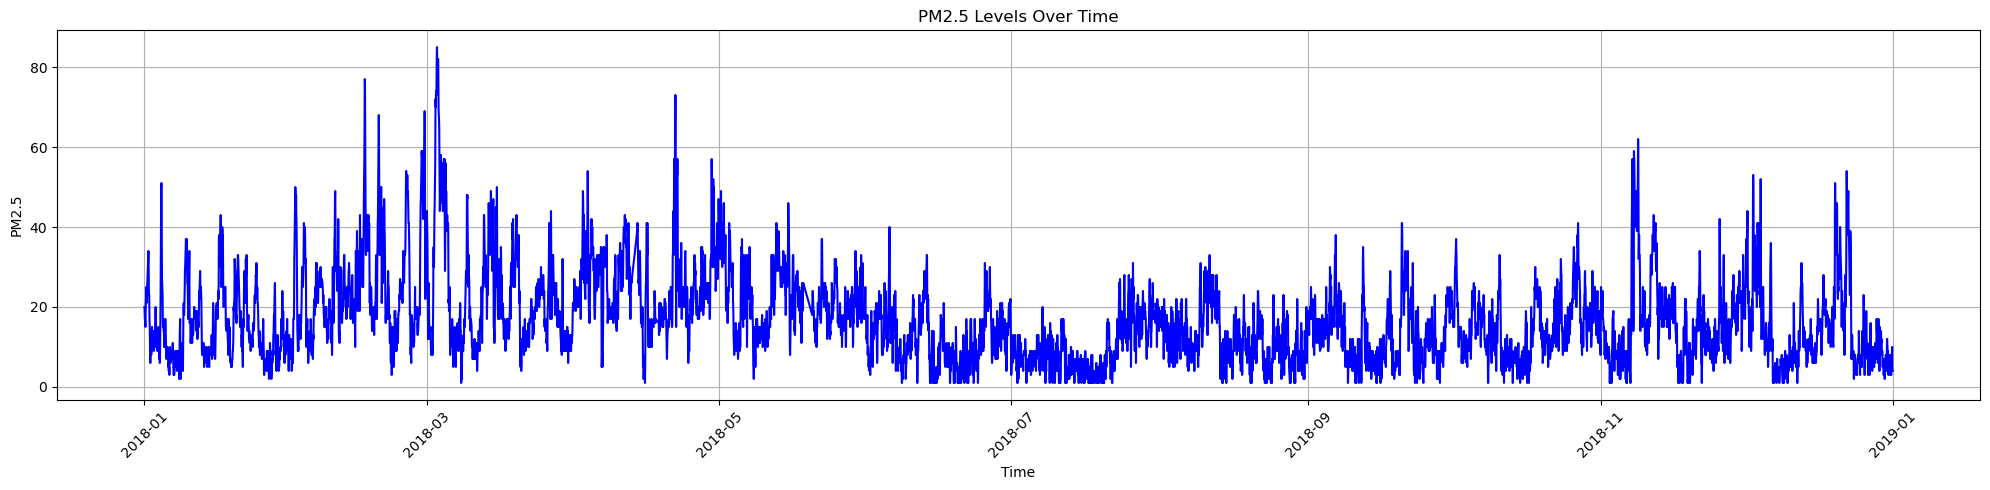

In [7]:
fig, ax = plt.subplots(figsize = (20,5))

ax.plot(
    pm25_cailiao['readtime'], 
    pm25_cailiao['pm25'], 
    # marker='o', 
    linestyle='-', 
    color='b'
    )
plt.title('PM2.5 Levels Over Time')
plt.xlabel('Time')
plt.ylabel('PM2.5')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

# Training

## Define Training Dataset

In [8]:
train_split = 0.6

train_data = pm25_cailiao.iloc[:int(len(pm25_cailiao)*train_split),:]
print(f"All data length:{len(pm25_cailiao)} \nTrain data length:{len(train_data)}")
train_data.tail()

All data length:8760 
Train data length:5256


,siteengname,pm25,ambtemp,ch4,co,nmhc,readtime
399077,Banqiao,11.0,31.4,1.8,0.41,0.13,2018-08-07 19:00:00
399153,Banqiao,11.0,30.8,1.8,0.35,0.10,2018-08-07 20:00:00
399229,Banqiao,10.0,30.4,1.8,0.31,0.09,2018-08-07 21:00:00
399305,Banqiao,8.0,30.2,1.8,0.30,0.08,2018-08-07 22:00:00
399381,Banqiao,9.0,29.9,1.8,0.23,0.06,2018-08-07 23:00:00


In [9]:
# min_pm = train_data['pm25'].min()
# max_pm = train_data['pm25'].max()

# print(f"PM2.5 Minimum: {min_pm}\nPM2.5 Minimum: {max_pm}")

In [10]:
# normalization
# train_data.loc[:, 'pm25_n'] = (train_data['pm25'] - min_pm) / (max_pm- min_pm)

# Calculate the normalized columns and create new columns with them
normalized_columns = ['pm25', 'ambtemp', 'ch4', 'co', 'nmhc']

for column in normalized_columns:
    normalized_column_name = column + '_normalized'
    train_data[normalized_column_name] = (train_data[column] - train_data[column].min()) / (train_data[column].max() - train_data[column].min())

C:\Users\arasyidi\AppData\Local\Temp\ipykernel_30956\3021661121.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data[normalized_column_name] = (train_data[column] - train_data[column].min()) / (train_data[column].max() - train_data[column].min())
C:\Users\arasyidi\AppData\Local\Temp\ipykernel_30956\3021661121.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data[normalized_column_name] = (train_data[column] - train_data[column].min()) / (train_data[column].max() - train_data[column].min()

In [11]:
class MarketDataset(Dataset):
    def __init__(self, data, history_len):
        self.data = data
        self.history_len = history_len
        
    def __len__(self):
        self.len = len(self.data) - self.history_len  
        return self.len
    
    def __getitem__(self, index):
        x_cols = ['pm25_normalized', 'ambtemp_normalized', 'ch4_normalized', 'co_normalized', 'nmhc_normalized']
        y_cols = ['pm25_normalized']
        x = self.data.iloc[index: index+self.history_len, :][x_cols].values
        y = self.data.iloc[index+self.history_len, :][y_cols].values.astype('float')
        x = torch.tensor(x).float()
        y = torch.tensor(y).float()
        return x, y

In [12]:
# verify dataset instances
train_dataset = MarketDataset(train_data, history_len=48)
print(len(train_dataset))
x, y = train_dataset[0]
print(x.shape, y.shape)

5208
torch.Size([48, 5]) torch.Size([1])


In [13]:
# train data_loader
train_data_loader = DataLoader(train_dataset, batch_size=4)
X, Y = next(iter(train_data_loader))
print(X.shape, Y.shape)

torch.Size([4, 48, 5]) torch.Size([4, 1])


In [14]:
class LSTNet(nn.Module):
    
    def __init__(self):
        super(LSTNet, self).__init__()
        self.num_features = 5
        self.conv1_out_channels = 32 
        self.conv1_kernel_height = 7
        self.recc1_out_channels = 64 
        self.skip_steps = [4, 24] 
        self.skip_reccs_out_channels = [4, 4] 
        self.output_out_features = 1
        self.ar_window_size = 7
        self.dropout = nn.Dropout(p = 0.2)
        
        self.conv1 = nn.Conv2d(1, self.conv1_out_channels, 
                               kernel_size=(self.conv1_kernel_height, self.num_features))
        self.recc1 = nn.GRU(self.conv1_out_channels, self.recc1_out_channels, batch_first=True)
        self.skip_reccs = {}
        for i in range(len(self.skip_steps)):
            self.skip_reccs[i] = nn.GRU(self.conv1_out_channels, self.skip_reccs_out_channels[i], batch_first=True)
        self.output_in_features = self.recc1_out_channels + np.dot(self.skip_steps, self.skip_reccs_out_channels)
        self.output = nn.Linear(self.output_in_features, self.output_out_features)
        if self.ar_window_size > 0:
            self.ar = nn.Linear(self.ar_window_size, 1)
        
    def forward(self, X):
        """
        Parameters:
        X (tensor) [batch_size, time_steps, num_features]
        """
        batch_size = X.size(0)
        
        # Convolutional Layer
        C = X.unsqueeze(1) # [batch_size, num_channels=1, time_steps, num_features]
        C = F.relu(self.conv1(C)) # [batch_size, conv1_out_channels, shrinked_time_steps, 1]
        C = self.dropout(C)
        C = torch.squeeze(C, 3) # [batch_size, conv1_out_channels, shrinked_time_steps]
        
        # Recurrent Layer
        R = C.permute(0, 2, 1) # [batch_size, shrinked_time_steps, conv1_out_channels]
        out, hidden = self.recc1(R) # [batch_size, shrinked_time_steps, recc_out_channels]
        R = out[:, -1, :] # [batch_size, recc_out_channels]
        R = self.dropout(R)
        #print(R.shape)
        
        # Skip Recurrent Layers
        shrinked_time_steps = C.size(2)
        for i in range(len(self.skip_steps)):
            skip_step = self.skip_steps[i]
            skip_sequence_len = shrinked_time_steps // skip_step
            # shrinked_time_steps shrinked further
            S = C[:, :, -skip_sequence_len*skip_step:] # [batch_size, conv1_out_channels, shrinked_time_steps]
            S = S.view(S.size(0), S.size(1), skip_sequence_len, skip_step) # [batch_size, conv1_out_channels, skip_sequence_len, skip_step=num_skip_components]
            # note that num_skip_components = skip_step
            S = S.permute(0, 3, 2, 1).contiguous() # [batch_size, skip_step=num_skip_components, skip_sequence_len, conv1_out_channels]
            S = S.view(S.size(0)*S.size(1), S.size(2), S.size(3))  # [batch_size*num_skip_components, skip_sequence_len, conv1_out_channels]
            out, hidden = self.skip_reccs[i](S) # [batch_size*num_skip_components, skip_sequence_len, skip_reccs_out_channels[i]]
            S = out[:, -1, :] # [batch_size*num_skip_components, skip_reccs_out_channels[i]]
            S = S.view(batch_size, skip_step*S.size(1)) # [batch_size, num_skip_components*skip_reccs_out_channels[i]]
            S = self.dropout(S)
            R = torch.cat((R, S), 1) # [batch_size, recc_out_channels + skip_reccs_out_channels * num_skip_components]
            #print(S.shape)
        #print(R.shape)
        
        # Output Layer
        O = F.relu(self.output(R)) # [batch_size, output_out_features=1]
        
        if self.ar_window_size > 0:
            # set dim3 based on output_out_features
            AR = X[:, -self.ar_window_size:, 3:4] # [batch_size, ar_window_size, output_out_features=1]
            AR = AR.permute(0, 2, 1).contiguous() # [batch_size, output_out_features, ar_window_size]
            AR = self.ar(AR) # [batch_size, output_out_features, 1]
            AR = AR.squeeze(2) # [batch_size, output_out_features]
            O = O + AR
        
        return O

In [15]:
# test model
model = LSTNet()

for X, Y in train_data_loader:
    print(X.shape)
    out = model(X)
    print(Y.shape, out.shape)
    break

torch.Size([4, 48, 5])
torch.Size([4, 1]) torch.Size([4, 1])


In [16]:
history_len = 48
batch_size = 8 

epochs = 10

lr = 0.01
weight_decay = 0.01

In [17]:
train_dataset = MarketDataset(train_data, history_len=history_len)
train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

model = LSTNet()

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

In [18]:
train_loss_list = []
for epoch in tqdm(range(epochs)):
    
    epoch_loss_train = 0
    for i, batch in tqdm(
        enumerate(train_data_loader, start=1),
        leave=False, desc="Train", total=len(train_data_loader)
        ):
        
        X, Y = batch
        optimizer.zero_grad()
        Y_pred = model(X)
        loss = criterion(Y_pred, Y)
        loss.backward()
        optimizer.step()
        
        with open('Running-Loss.txt', 'a+') as file:
            file.write(f'{loss.item()}\n')
        epoch_loss_train += loss.item()
        
    epoch_loss_train = epoch_loss_train / len(train_data_loader)
    train_loss_list.append(epoch_loss_train)
    
    with open('Epoch-Loss.txt', 'a+') as file:
        file.write(f'{epoch_loss_train}\n')

  0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/651 [00:00<?, ?it/s]

Train:   0%|          | 0/651 [00:00<?, ?it/s]

Train:   0%|          | 0/651 [00:00<?, ?it/s]

Train:   0%|          | 0/651 [00:00<?, ?it/s]

Train:   0%|          | 0/651 [00:00<?, ?it/s]

Train:   0%|          | 0/651 [00:00<?, ?it/s]

Train:   0%|          | 0/651 [00:00<?, ?it/s]

Train:   0%|          | 0/651 [00:00<?, ?it/s]

Train:   0%|          | 0/651 [00:00<?, ?it/s]

Train:   0%|          | 0/651 [00:00<?, ?it/s]

In [31]:
epoch_loss = pd.read_table("Epoch-Loss.txt", header=None)
running_loss = pd.read_table("Running-Loss.txt", header=None)

<Axes: >

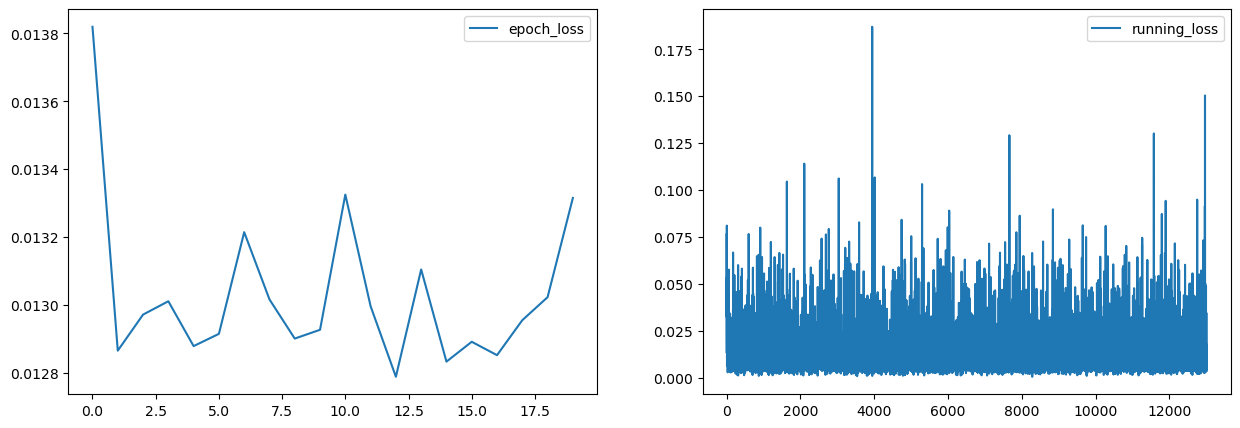

In [37]:
fig, ax = plt.subplots(1,2, figsize=(15,5))

epoch_loss.plot(
    y = 0,
    label = "epoch_loss",
    ax=ax[0]
)

running_loss.plot(
    y = 0,
    label = "running_loss",
    ax=ax[1]
)

In [19]:
model_name = f"LSTNet-E{epochs}"
model_path = f"{model_name}.pth"
torch.save(model.state_dict(), model_path)

In [20]:
# model_name = f"LSTNet-E{epochs}"
# model_path = f"{model_name}.pth"
# model = LSTNet()
# model.load_state_dict(torch.load(model_path))
# model.eval()

In [21]:
train_split = 0.6

test_data = pm25_cailiao.iloc[int(len(pm25_cailiao)*train_split):,:]
print(f"All data length:{len(pm25_cailiao)} \nTrain data length:{len(test_data)}")
test_data.head()

All data length:8760 
Train data length:3504


,siteengname,pm25,ambtemp,ch4,co,nmhc,readtime
399457,Banqiao,9.0,29.8,1.8,0.18,0.05,2018-08-08 00:00:00
399533,Banqiao,7.0,29.8,1.8,0.15,0.07,2018-08-08 01:00:00
399609,Banqiao,7.0,29.6,1.8,0.15,0.13,2018-08-08 02:00:00
399685,Banqiao,7.0,29.3,1.9,0.15,0.15,2018-08-08 03:00:00
399761,Banqiao,4.0,28.9,1.9,0.15,0.16,2018-08-08 04:00:00


In [22]:
# normalization
# test_data.loc[:, 'pm25_n'] = (test_data['pm25'] - min_pm) / (max_pm- min_pm)

# Calculate the normalized columns and create new columns with them
normalized_columns = ['pm25', 'ambtemp', 'ch4', 'co', 'nmhc']

for column in normalized_columns:
    normalized_column_name = column + '_normalized'
    test_data[normalized_column_name] = (test_data[column] - test_data[column].min()) / (test_data[column].max() - test_data[column].min())

C:\Users\arasyidi\AppData\Local\Temp\ipykernel_30956\1743648032.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data[normalized_column_name] = (test_data[column] - test_data[column].min()) / (test_data[column].max() - test_data[column].min())
C:\Users\arasyidi\AppData\Local\Temp\ipykernel_30956\1743648032.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data[normalized_column_name] = (test_data[column] - test_data[column].min()) / (test_data[column].max() - test_data[column].min())
C:\Users

In [23]:
batch_size = 16
dataset = MarketDataset(test_data, history_len=history_len)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

In [24]:
for i, batch in tqdm(enumerate(data_loader, start=1),leave=False, total=len(data_loader)):
    X, Y = batch
    Y_pred = model(X).detach().numpy()
    if i == 1:
        predictions = Y_pred
    else:
        predictions = np.concatenate((predictions, Y_pred), axis=0)

min_pm = test_data['pm25'].min()
max_pm = test_data['pm25'].max()

#predictions[:, 0:4] = predictions[:, 0:4] * (max_pm - min_pm) + min_pm
#predictions[:, 4] = predictions[:, 4] * (max_volume - min_volume) + min_volume
predictions = predictions * (max_pm - min_pm) + min_pm

#columns = ['Open', 'High', 'Low', 'Close', 'Volume']
columns = ['pm25']
predictions = pd.DataFrame(predictions, columns=columns)
print(predictions.shape)
predictions.head()

  0%|          | 0/216 [00:00<?, ?it/s]

(3456, 1)


,pm25
0,17.019258
1,15.840887
2,14.869803
3,14.920429
4,15.137044


In [25]:
print(data.shape)
print(predictions.shape)

(665760, 31)
(3456, 1)


In [26]:
predictions['readtime'] = test_data.reset_index()['readtime']
predictions.head()

,pm25,readtime
0,17.019258,2018-08-08 00:00:00
1,15.840887,2018-08-08 01:00:00
2,14.869803,2018-08-08 02:00:00
3,14.920429,2018-08-08 03:00:00
4,15.137044,2018-08-08 04:00:00


<Axes: xlabel='readtime'>

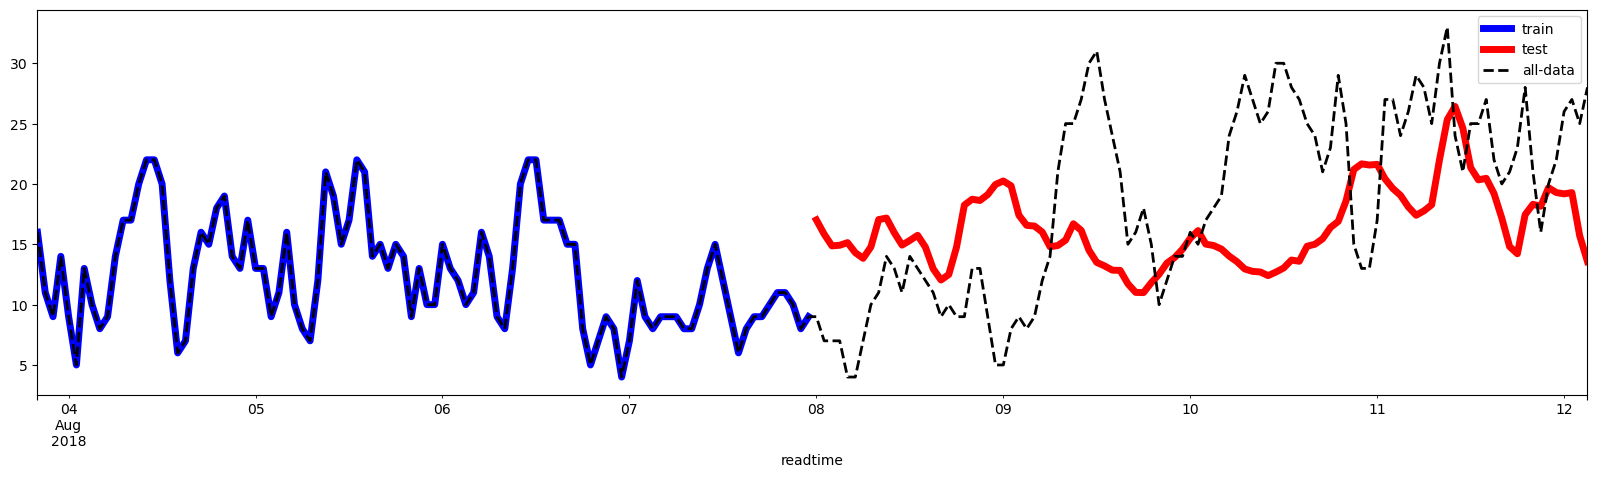

In [27]:
fig, ax = plt.subplots(figsize = (20,5))

length = 100

train_data.reset_index().tail(length).plot(
    x="readtime",
    y="pm25",
    ax=ax,
    label="train",
    color="blue",
    lw=5
    )

predictions.head(length).plot(
    x="readtime",
    y="pm25",
    ax=ax,
    label="test",
    color="red",
    lw=5
    )

pm25_cailiao.reset_index().iloc[len(train_data)-length:len(train_data)+length,:].plot(
    x="readtime",
    y="pm25",
    linestyle='--',
    ax=ax,
    label="all-data",
    color="black",
    # alpha=0.8,
    lw=2
    )

<Axes: xlabel='readtime'>

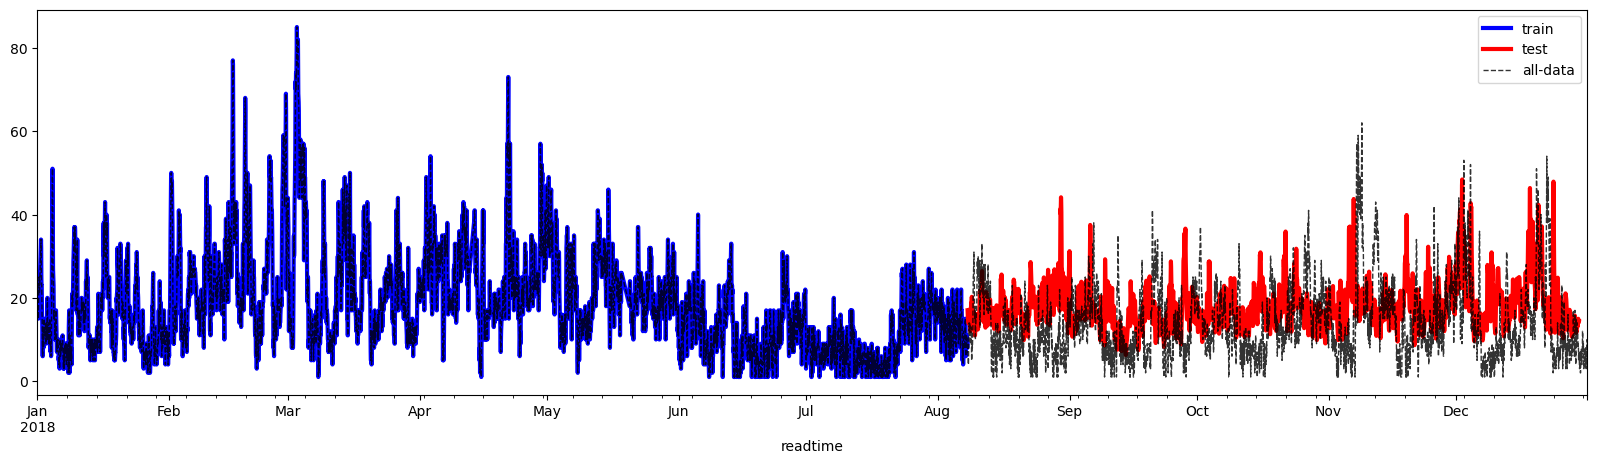

In [28]:
fig, ax = plt.subplots(figsize = (20,5))

train_data.reset_index().plot(
    x="readtime",
    y="pm25",
    ax=ax,
    label="train",
    color="blue",
    lw=3
    )

predictions.plot(
    x="readtime",
    y="pm25",
    ax=ax,
    label="test",
    color="red",
    lw=3
    )

pm25_cailiao.reset_index().plot(
    x="readtime",
    y="pm25",
    linestyle='--',
    ax=ax,
    label="all-data",
    color="black",
    alpha=0.8,
    lw=1
    )